In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import pickle
from modules.functions import pymatgen_comp, data_generator_vec, check_cuda, get_comp
from modules.trained_models import get_uts_without_grain
from modules.pytorch_models import Generator, Discriminator
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import tqdm

In [3]:
el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

with open('misc/scaler_y.pkl','rb') as fid:
    uts_scaler = pickle.load(fid)

In [4]:
dataset = pd.read_csv('dataset/synthetic_dataset_test.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'], el_list=el_list)
vec_comps = comp_dset.real_data

properties = ['uts1200C','price','density']

y = to_train_df.loc[:,properties].values.reshape(-1,len(properties)).astype('float32')
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)
kde = KernelDensity(kernel='gaussian',bandwidth=0.5)
v = kde.fit(y_scaled)

with open('misc/scaler_y_multi.pkl','wb') as fid:
    pickle.dump(scaler, fid)

In [5]:
def prop_sampler(n_samples):
    return kde.sample(n_samples).astype('float32')

def noise_sampler(N, z_dim):
    return np.random.normal(size=[N, z_dim]).astype('float32')


def plot(points,dset, title,  thresh=0.01):

    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    ax = ax.flatten()
    ax[0].set_title(title)
    ax[0].violinplot(points, np.arange(points.shape[1]))
    ax[0].set_xticks(np.arange(dset.size))
    ax[0].set_xticklabels(dset.elements)
    s = points.sum(axis=1)
    if np.max(s) - np.min(s) < 0.010:
        ax[1].hist(s, np.linspace(0.990, 1.010, 6))
    else:
        ax[1].hist(s)
    ax[2].hist(points.flatten())
    ne = (points > thresh).sum(axis=1)
    ax[3].hist(ne, np.arange(0, 12), width=0.80)
    plt.show()
    plt.close()


In [6]:
batch_size = 1000
minibatch_size = batch_size
prop_dim = y_scaled.shape[1]
latent_dim = 4
gen_in = latent_dim + prop_dim
hidden = gen_in*2
n_hidden = 3
gen_out = comp_dset.size
generator = Generator(gen_in,n_hidden,hidden,gen_out)
discriminator = Discriminator(gen_out+prop_dim,n_hidden,hidden,1)
optim_betas = (0.5, 0.999)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001,betas=optim_betas)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001,betas=optim_betas)
loss = nn.BCELoss()
d_steps = 1
g_steps = 1
prefix = 'Epoch'
cuda = check_cuda()
num_iterations = int(2e4)
log_interval = int(5e2)

/noether/s0/aqd5773/anaconda3/envs/candidate_generation/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

In [8]:
def d_loop(dset=comp_dset, scaled_props = y_scaled):
  discriminator_optimizer.zero_grad()
  train_data, train_idx = dset.sample(batch_size)
  train_prop = scaled_props[train_idx]
  d_real_data = torch.from_numpy(train_data)
  d_real_prop = torch.from_numpy(train_prop)
  if cuda:
        d_real_data = d_real_data.cuda()
        d_real_prop = d_real_prop.cuda()
  
  true_discriminator_out = discriminator(d_real_data,d_real_prop)
  true_labels = torch.ones_like(true_discriminator_out)
  true_discriminator_loss = loss(true_discriminator_out, true_labels)


  d_gen_input = torch.from_numpy(noise_sampler(batch_size, latent_dim))
  d_gen_prop = prop_sampler(batch_size)
  d_gen_prop =  torch.from_numpy(d_gen_prop)#sample between lowest and highest LC values, uniform 
  if cuda:
        d_gen_input = d_gen_input.cuda()
        d_gen_prop = d_gen_prop.cuda()
  with torch.no_grad():
        generated_data = generator(d_gen_input,d_gen_prop)
  
  generator_discriminator_out = discriminator(generated_data.detach(),d_gen_prop)
  generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros_like(generator_discriminator_out))
  discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
  discriminator_loss.backward()
  discriminator_optimizer.step()

In [9]:
def g_loop():
  generator_optimizer.zero_grad()
  
  d_gen_input = torch.from_numpy(noise_sampler(batch_size, latent_dim))
  d_gen_prop = prop_sampler(batch_size)
  d_gen_prop =  torch.from_numpy(d_gen_prop)#sample between lowest and highest LC values, uniform 
  if cuda:
        d_gen_input = d_gen_input.cuda()
        d_gen_prop = d_gen_prop.cuda()
  generated_data = generator(d_gen_input,d_gen_prop)
  generator_discriminator_out = discriminator(generated_data,d_gen_prop)
  true_labels = torch.ones_like(generator_discriminator_out)
  generator_loss = loss(generator_discriminator_out, true_labels)
  generator_loss.backward()
  generator_optimizer.step()

In [10]:
def g_sample():
    with torch.no_grad():
        gen_input = torch.from_numpy(noise_sampler(minibatch_size, latent_dim))
        #prop_input = np.random.uniform(max,min,(minibatch_size,prop_dim)).astype('float32')
        prop_input = prop_sampler(minibatch_size)
        prop_input =  torch.from_numpy(prop_input)
        if cuda:
            gen_input = gen_input.cuda()
            prop_input = prop_input.cuda()
        g_fake_data = generator(gen_input,prop_input)
        return g_fake_data.cpu().numpy()

  0%|          | 0/20000 [00:00<?, ?it/s]

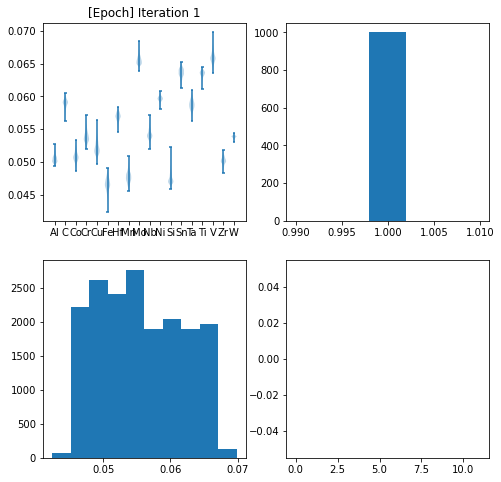

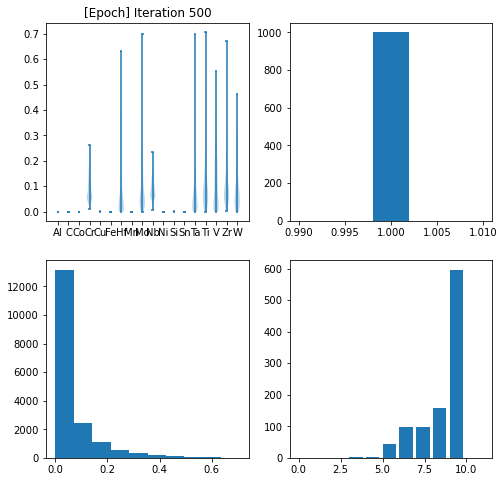

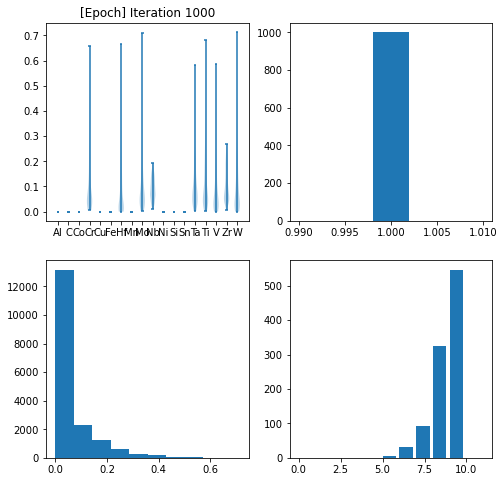

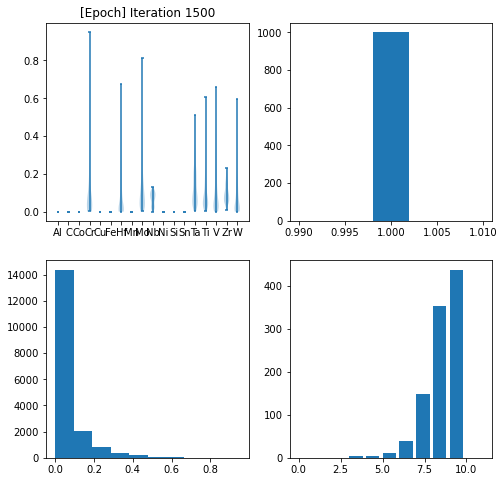

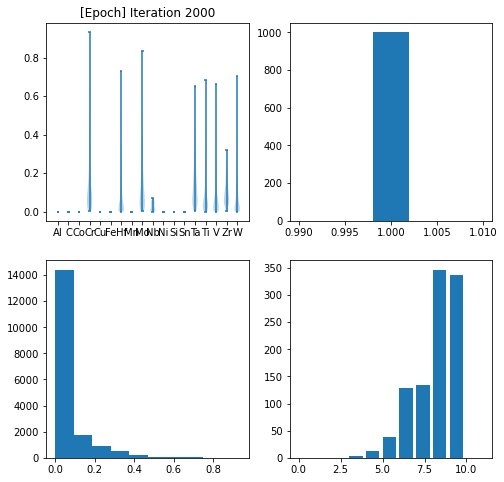

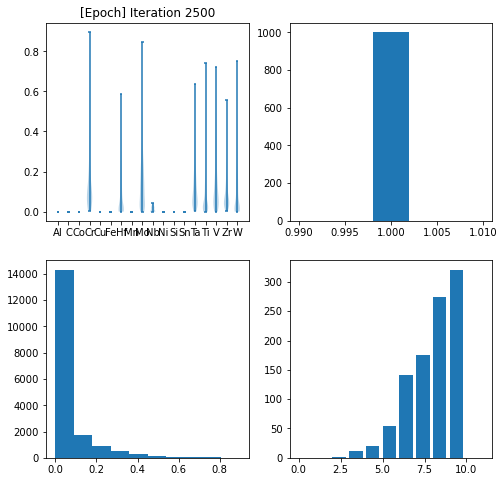

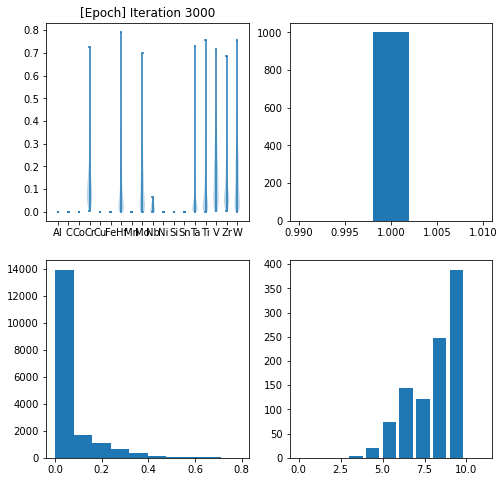

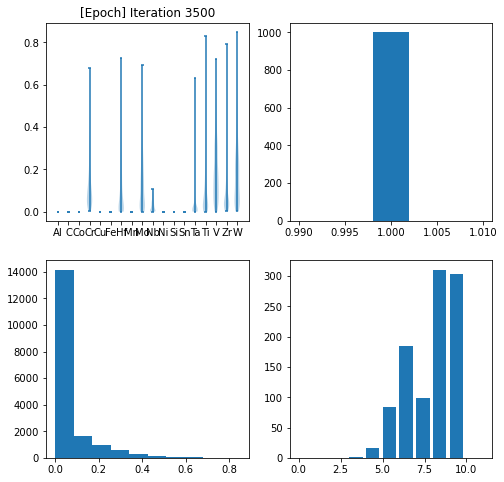

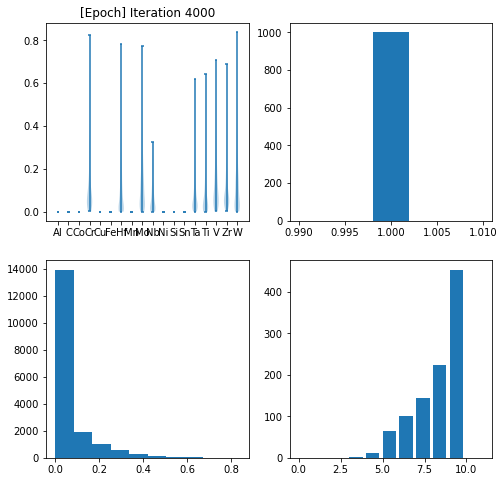

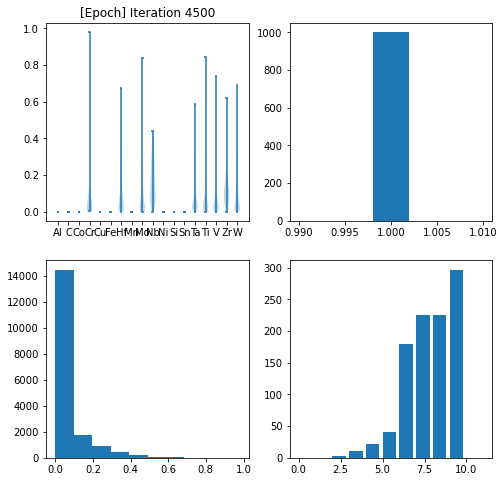

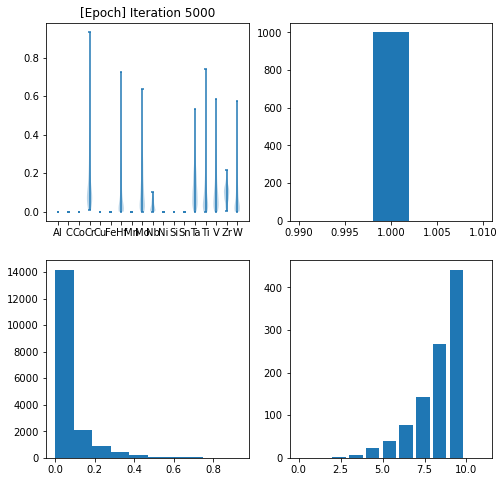

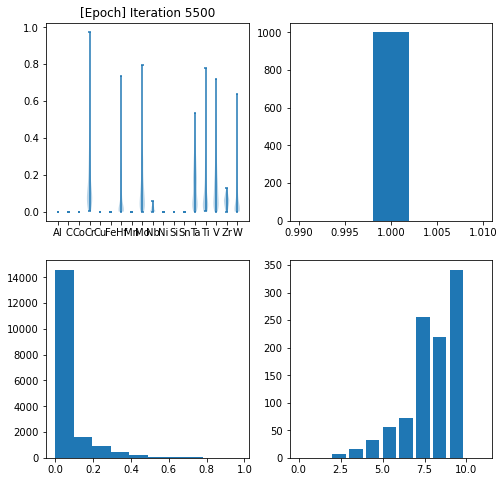

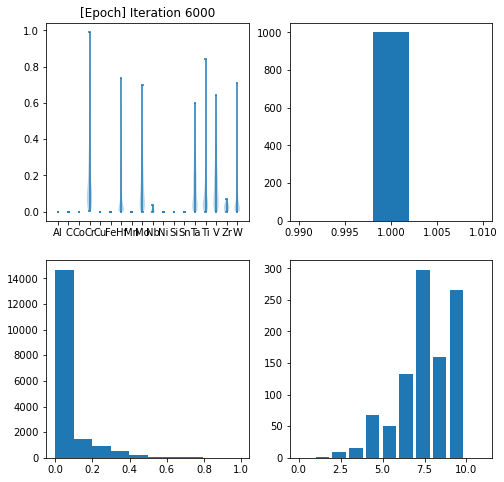

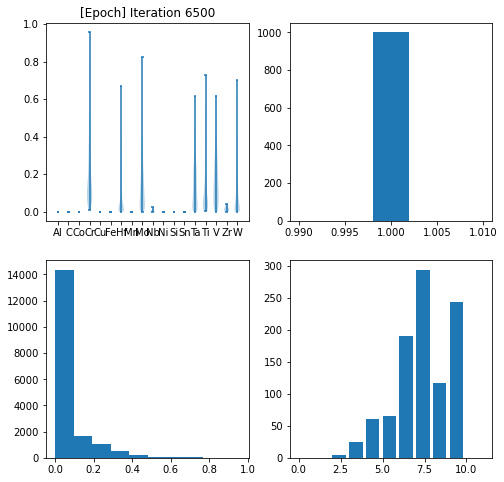

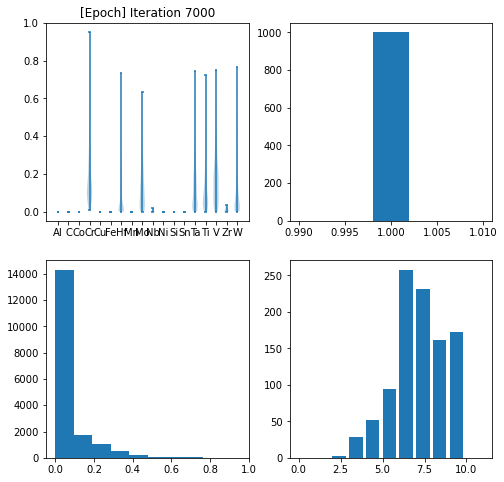

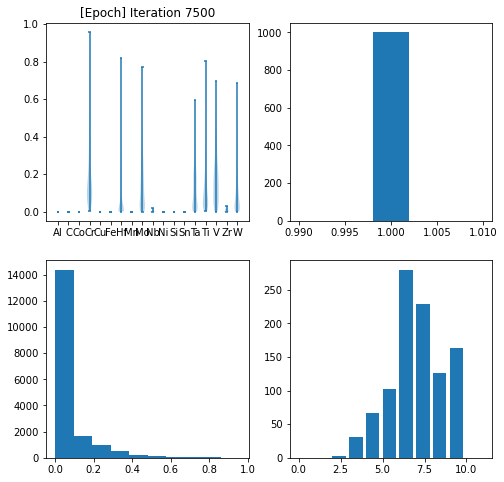

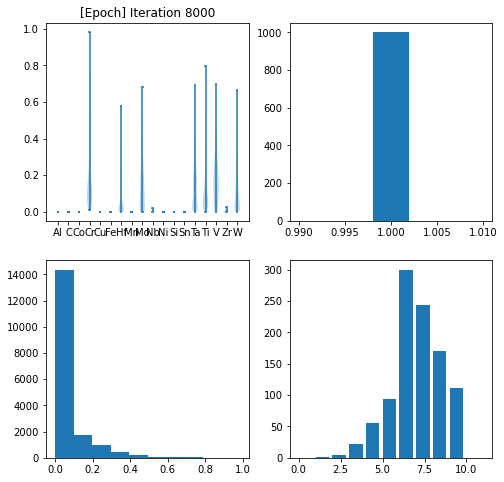

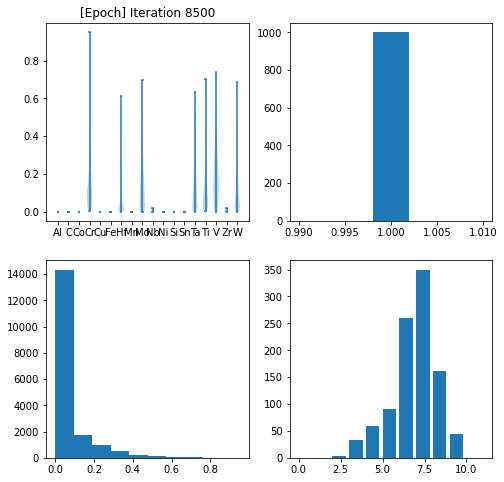

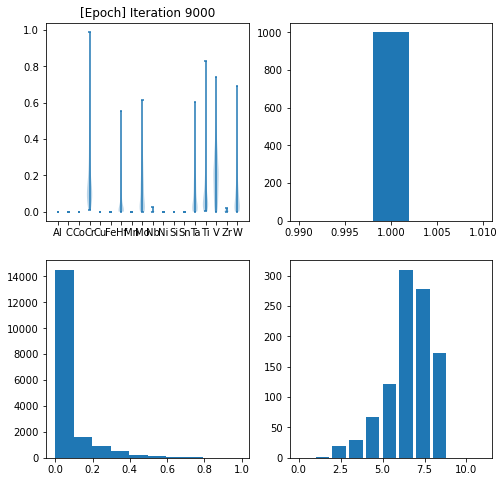

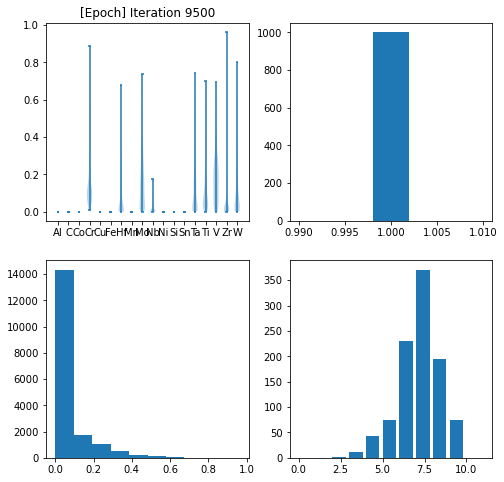

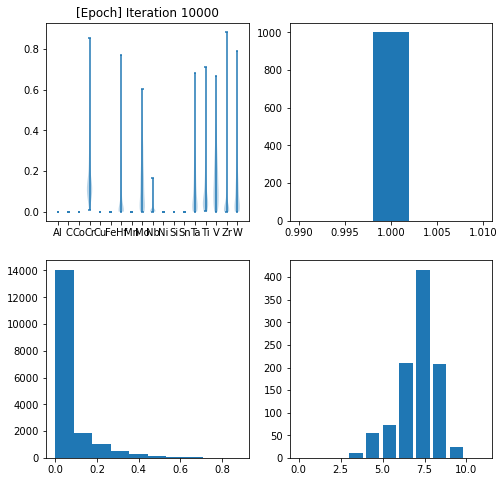

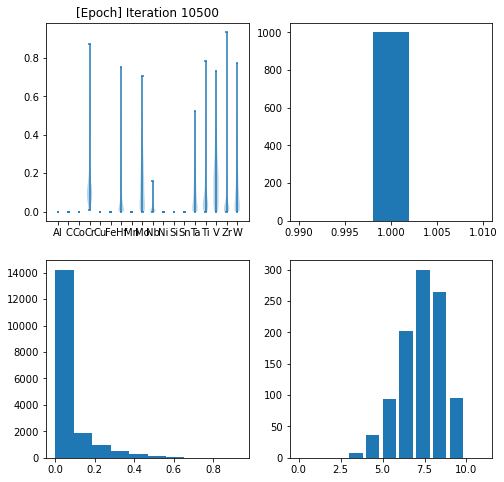

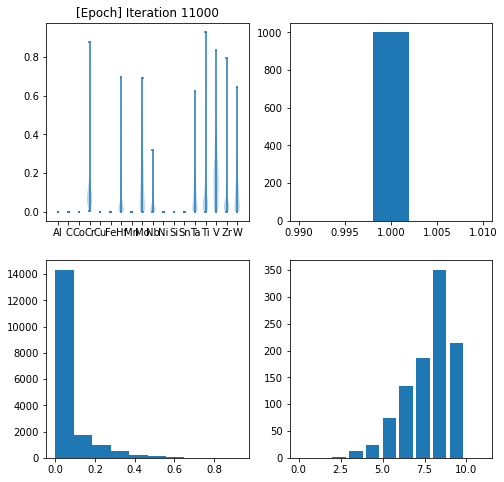

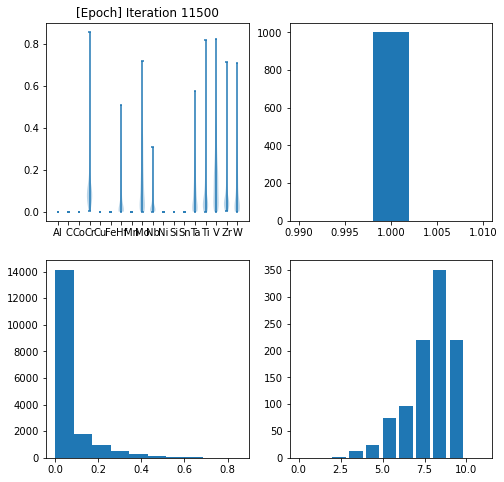

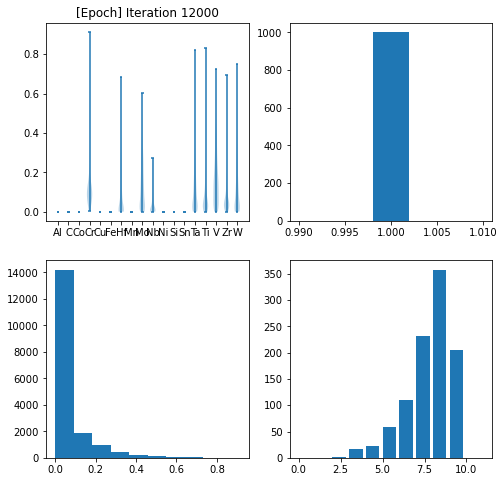

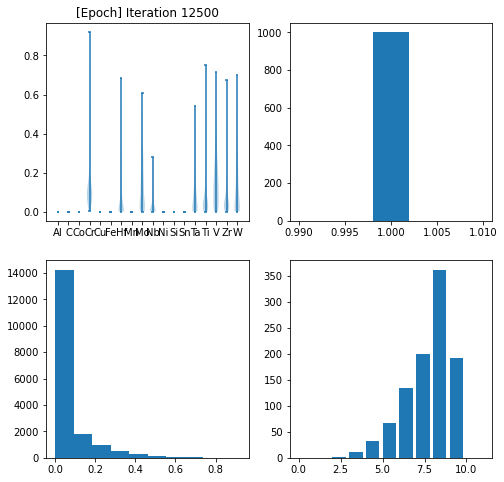

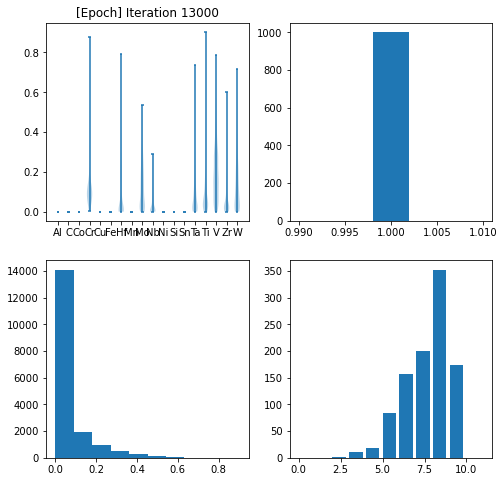

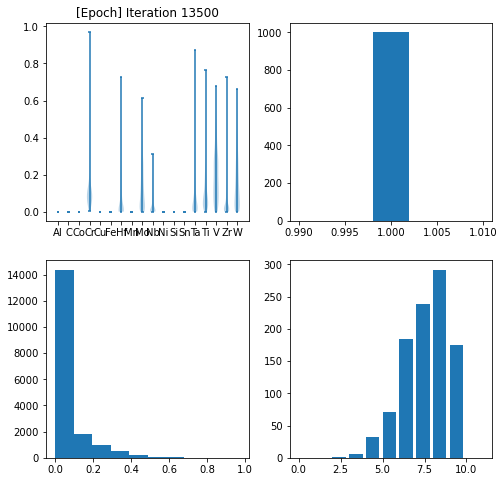

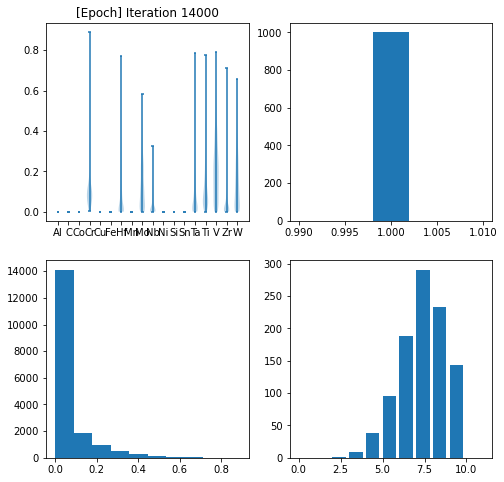

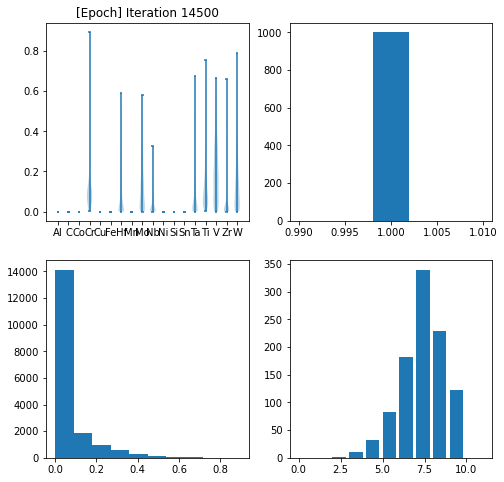

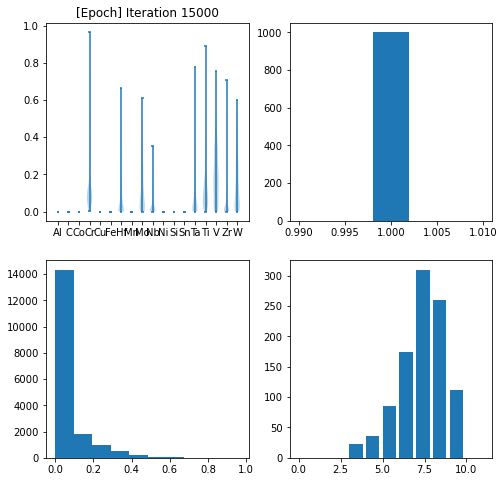

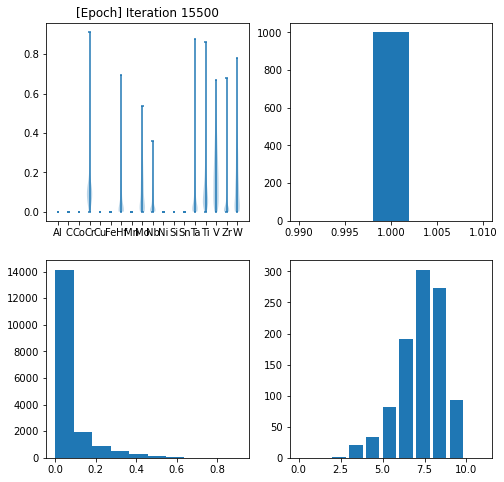

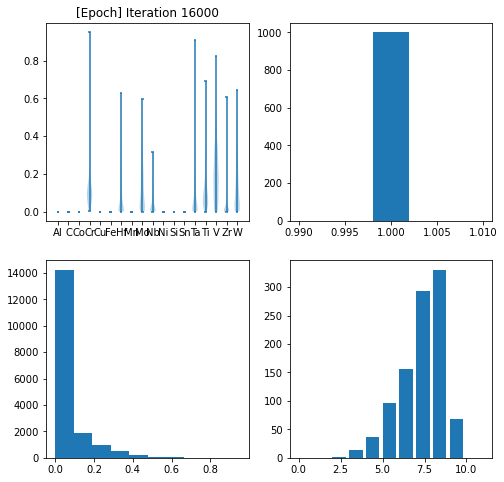

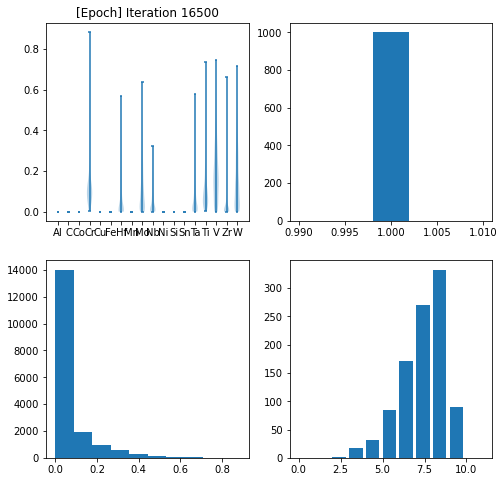

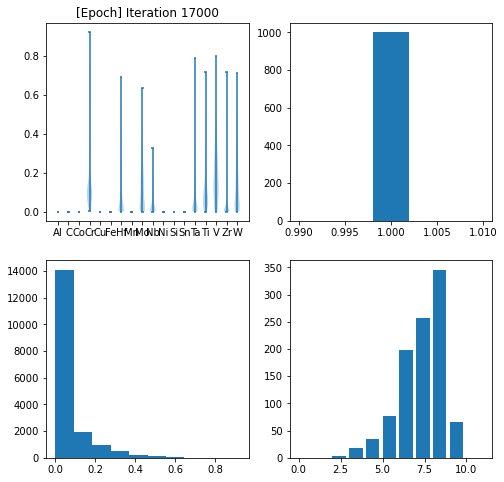

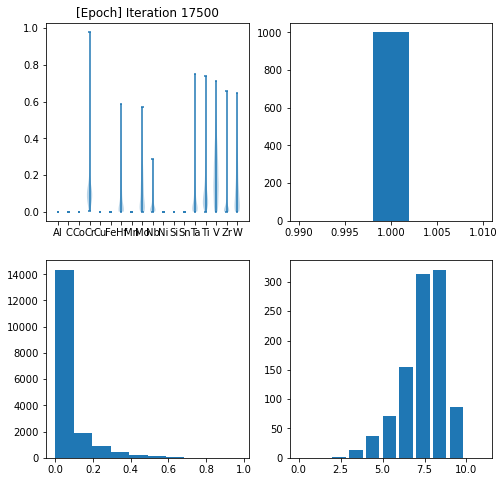

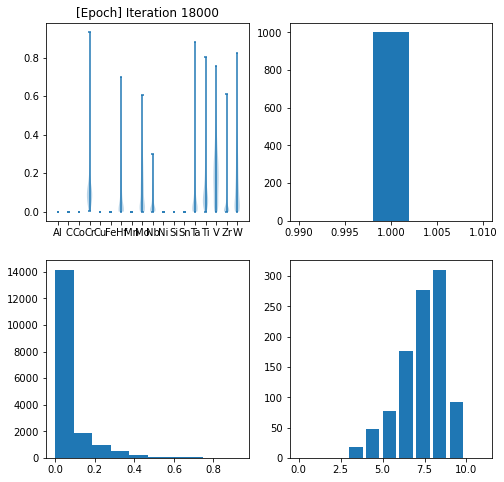

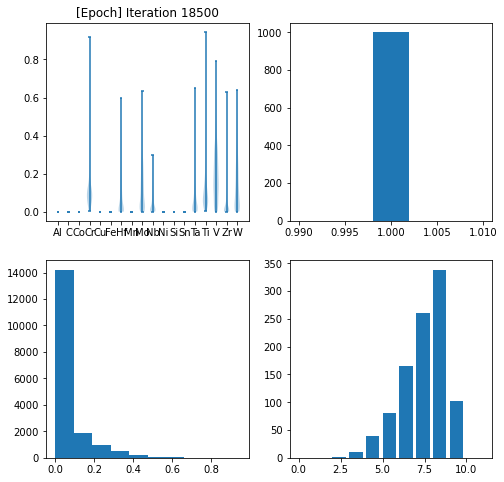

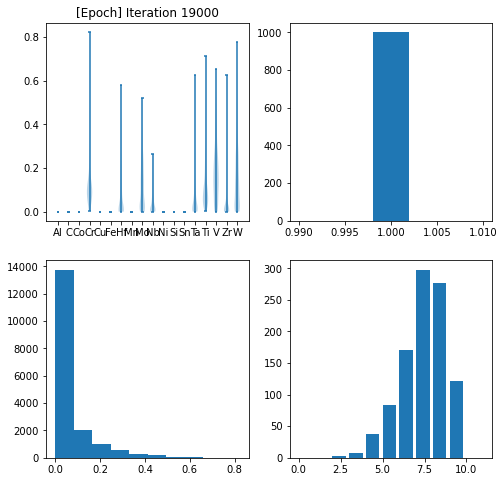

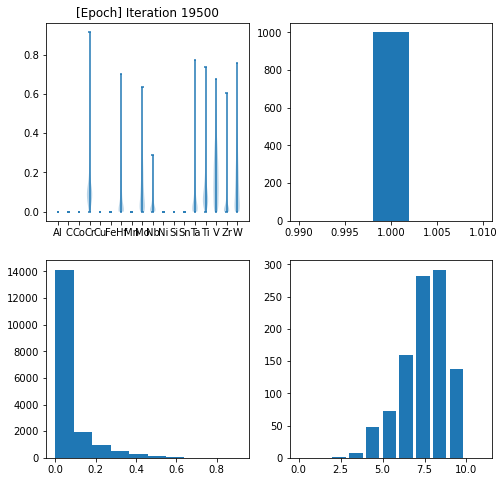

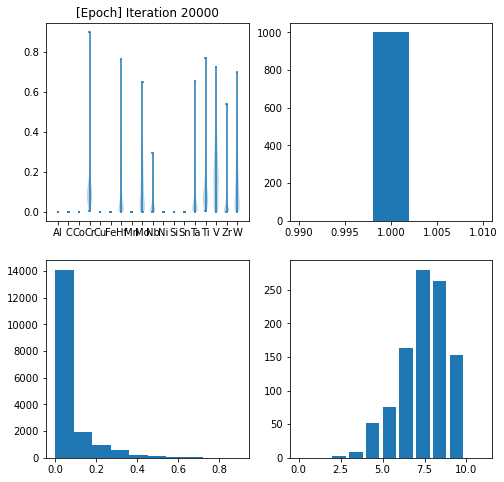

In [87]:
samples = []
for it in tqdm.notebook.tqdm(range(num_iterations), total=num_iterations):
    d_infos = []
    for d_index in range(d_steps):
        d_loop()
    for g_index in range(g_steps):
        g_loop()
    
    if it == 0 or (it + 1) % log_interval == 0:
        g_fake_data = g_sample()
        samples.append(g_fake_data)
        plot(g_fake_data, title='[{}] Iteration {}'.format(prefix, it+1),dset = comp_dset)
        train_epoch = it+1

model_path = 'saved_models'
model_scripted = torch.jit.script(generator.cpu())
model_scripted.save(os.path.join(model_path, 'GAN_generator_multi.pt'))

In [18]:
from modules.trained_models import get_uts_without_grain

scaled_fixed_conds = np.linspace(0,1.4,5) + 0.25
l = [40,8.6]
other = np.ones((len(scaled_fixed_conds),2))*l

sc_fixed_conds = np.concatenate((scaled_fixed_conds.reshape(-1,1),other), axis=1)
fixed_cond_vals = scaler.transform(sc_fixed_conds)
n_samples = 500
parity_dict = {}
for i,val in enumerate(fixed_cond_vals):
    ones_arr = (np.ones((n_samples,fixed_cond_vals.shape[1]))*val).astype('float32')
    random_noise = noise_sampler(n_samples,latent_dim)
    gen_input = torch.from_numpy(random_noise)
    prop_input = torch.from_numpy(ones_arr)
    if cuda:
        generator = generator.cuda()
        gen_input = gen_input.cuda()
        prop_input = prop_input.cuda()
    g_fake_data = generator(gen_input,prop_input).to('cpu').detach().numpy()
    uts_synthetic = [get_uts_without_grain(i.reshape(1,-1)).item() for i in g_fake_data]
    scaled_val = scaler.inverse_transform(fixed_cond_vals)[i,0].item()
    parity_dict[scaled_val] = np.array(uts_synthetic)    

Text(0, 0.5, 'Sampled UTS1200C')

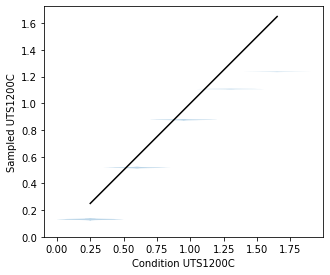

In [19]:
vals = np.array([np.array(x) for x in parity_dict.values()])
targets = scaled_fixed_conds
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(5,5))
_=ax.violinplot(vals.T, targets, showextrema=False, bw_method=0.2)
ax.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'k-')
ax.set_ylim(0)
ax.set_aspect('equal')
ax.set_xlabel('Condition UTS1200C')
ax.set_ylabel('Sampled UTS1200C')

In [11]:
model_path = 'saved_models'
if os.path.exists(os.path.join(model_path, 'GAN_generator_multi.pt')):
    generator = torch.jit.load(os.path.join(model_path, 'GAN_generator_multi.pt'), map_location='cpu')
else:
    print('train model first!')

In [12]:
import json
from modules.mongodb_rom import calculate_density, calculate_price
from modules.functions import get_comp
with open('misc/starting_comp.json','r') as fid:
    start_comp_dict = json.load(fid)

start_comp = start_comp_dict['start_comp']
start_comp_decoded = get_comp(np.array(start_comp), el_list)
#pmg_start_comp = pymatgen_comp([start_comp_decoded])[0]
start_uts = start_comp_dict['start_uts']
start_price = calculate_price(start_comp_decoded)
start_density = calculate_density(start_comp_decoded)

In [13]:
with open('results.json','r') as fid:
    results_dict = json.load(fid)

uniform_noise = results_dict['inverse']['constants']['uniform_noise']
w_ind = np.argwhere(el_list == 'W')

In [14]:
lc = noise_sampler(1,4)
c_unscaled = np.array([1.4, 31.54, 8.24]).reshape(1,-1)
c_scaled = scaler.transform(c_unscaled)
c = (np.ones((1,3))*c_scaled).astype('float32')


tc_t = torch.from_numpy(lc)
c = torch.from_numpy(c)
g_fake = generator(tc_t,c).to('cpu').detach().numpy()


In [15]:
get_uts_without_grain(g_fake[0].reshape(1,-1)).item(), calculate_price(get_comp(g_fake[0], el_list)), calculate_density(get_comp(g_fake[0], el_list))

(1.139304518699646, 26.599000000000004, 8.047399374067163)

In [16]:
from modules.mongodb_rom import calculate_entropy_mixing
t = get_comp(g_fake[0], el_list)
t,calculate_entropy_mixing(t)

(Comp: Ti0.27 Cr0.19 Mo0.54, -1.0017994409805908)

In [31]:
decoded_comp = [get_comp(x, el_list) for x in g_fake]
decoded_comp[0].reduced_formula

'Ti0.2Cr0.26Mo0.51W0.04'

In [111]:
decoded_comp = [get_comp(x, el_list) for x in g_fake]

json_dict = {
    'decoded_comp': decoded_comp[0].reduced_formula,
    'start_comp' : g_fake[0].tolist(),
    'start_uts' : get_uts_without_grain(g_fake[0].reshape(1,-1)).item(),
    'start_w_content' : g_fake[0][-1],
}

with open('misc/starting_comp_multi.json','wb') as fid:
    pickle.dump(json_dict,fid)

additional analysis

In [112]:
weights = sum(p.numel() for p in generator.parameters() if p.requires_grad)
print( f'model has {weights} trainable weights' )

model has 592 trainable weights


In [114]:
minibatch_size = 1
with torch.no_grad():
    gen_input = torch.from_numpy(noise_sampler(minibatch_size, latent_dim))
    prop_input = prop_sampler(minibatch_size)
    prop_input = torch.from_numpy(prop_input)

%timeit g_fake_data = generator(gen_input, prop_input)

76.4 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
